# Project Objectives
- Document code, process, findings, and key takeaways.
- Make your process repeateable and your report (notebook) easy to read and follow.
- Ask exploratory questions of your data. Answer questions through charts and statistical tests.
- Construct a model to predict Value ("tax assessment") using regression techniques.
- Refine your work into a Report.
- Be prepared to answer panel questions.

## Business Goals
- Find drivers for tax assessment with zillow data. What are features that can help predict tax assessment?
- Construct a ML regression model that accurately predicts tax assessment.
- Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

## Executive Summary
- While all imported features do have a level of significance in determining the Tax assessment, the main drivers come down to the key features of Location (FIPS and ZIP), Square footage (House and Lot), and the amount of Rooms (Bedrooms and Bathrooms). This in conjunction with the year built result in our ability to improve on baseline modeling.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import plotly.express as px

import acquire
import prepare
import explore
import wrangle
import modeling
import env

> - ## Acquire the data
> - fetches the data on the codeup server using cusotm sql query

In [2]:
## fetches data and gives us the shape
df0 = acquire.get_zillow_single_fam_2017()
df0.shape

(52441, 8)

> - ## Return a prep file
> - remove whitespace, rename FIPS codes, rename columns to easier to read formatting

In [3]:
## sends in the fetched dataframe and returns a prepared file and shows the shape
df = prepare.prep_zillow(df0)
df.shape

(52441, 8)

> - ## Return a wrangle file with some feature engineering
> - remove outliers using Tukey (k=1.5), this helps prevent skewing of the data in weird directions (20 bed 0 bath)
> - add a binned version of years (decades), (assists with exploration and generalizng years)
> - create a new column called "openness", this is the area of the house divided by bathrooms + bedrooms, a rough idea of how spacious the house may be
> - create a new column called "yard ratio", this is how many of that house would fit into the lot (how much land there would be in relation to the house)
> - checked and no nulls left
> - split data (60%,20%,20%)

In [4]:
##checking the distribution after removing outliers
df,train,validate,test = wrangle.wrangle_zillow_orig(df)
df.head(0)

prepared df shape: (40707, 11)
train shape: (24423, 11)
validate shape: (8142, 11)
test shape: (8142, 11)


,bedrooms,bathrooms,area,tax assessment,year built,fips,lot sqft,zip,decade built,openess,yard ratio


-
-
-

# Let's dive deeper into how features are related with a correlation heat map
- by utilizing a heat map we can get a quick answer on features that are directly related

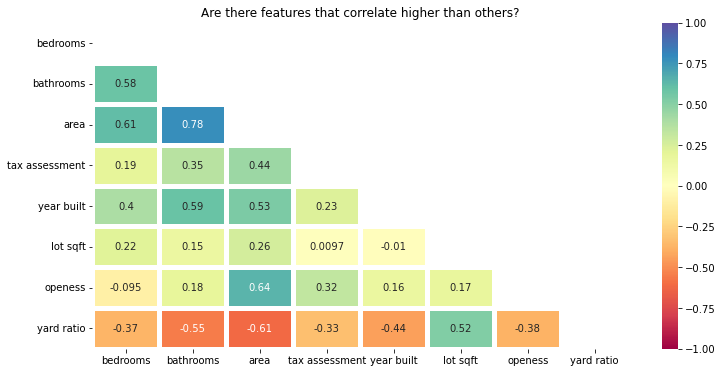

In [5]:
## create a heatmap of relationships between the variables
explore.heatmap_corr(train.sample(n=10000, random_state=123))

# Heatmap takeaways:
no particularly strong relations with tax assessment (our target), will need to use many features to help predict.

Area is well related to bedrooms and bathrooms, with the it being the strongest relation for tax assessment.
Lot sqft has almost 0 relation to tax assessment, this is also curious 

-
-
-

## Let's start asking our questions

> - ## Are the features of Tax Assessment and Year Built related?

> - **Hypothesis 1 -** 
> - alpha = .05
> - $H_0$ = "The distributions underlying the samples of Tax assessment and Year Built are unrelated"
> -
> - $H_a$: "The distributions underlying the samples of Tax assessment and Year Built are related"

created an explore function that takes in two strings (and data frame they are featured in), scatterplots the relation with a regression line for reference and returns the r and p value that result from the PearsonR correlation calculation

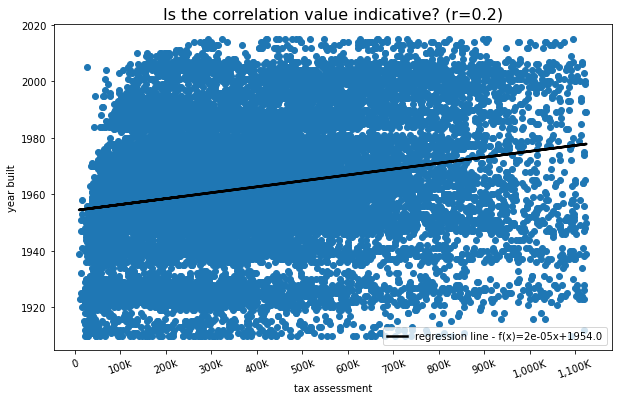

r = 0.23419468475014799

 We reject the null Hypothesis ( T̶h̶a̶t̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶s̶ ̶u̶n̶d̶e̶r̶l̶y̶i̶n̶g̶ ̶t̶h̶e̶ ̶s̶a̶m̶p̶l̶e̶s̶ ̶o̶f̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶a̶n̶d̶ ̶y̶e̶a̶r̶ ̶b̶u̶i̶l̶t̶ ̶a̶r̶e̶ ̶u̶n̶r̶e̶l̶a̶t̶e̶d̶ ) p=0.00000


In [6]:
## data is quantative, mostly normally distributed, and already removed most the outliers
## so will test with pearsonR

explore.pearsonr_corr_explore_plot(train,"tax assessment","year built")

### Correlation/PearsonR takeaway
- here we have a statistical test of PearsonR validating that there is a loose relationship between Tax assessment and Year Built with an r-value of 0.23. This loose correlation would indicate to me that while there is a level of value by having year built included in my modeling, it will not be a "Main Driver"

-
-
-

Continuing exploration of the heat map, we will test the Tax assessment mean of each FIPs to see if there is a difference in the means based on location

> - ## Does each main location (FIP) have a statistically signficant difference in values?

> - **Hypothesis 2 -** 
> - alpha = .05
> - $H_0$ = "Tax assessment of FIPS has identical average assessments to Tax assessment of other FIPS"
> - $\mu_{Tax assessment (FIPS_{n})} <= \mu_{Tax assessment (FIPS_{n+1})}$.
> -
> - $H_a$: "Tax assessment of FIPS is not equal to Tax assessment of other FIPS"
> - $\mu_{Tax assessment (FIPS_{n})} > \mu_{Tax assessment (FIPS_{n+1})}$. 

created an explore function that takes in two features, returns a variance check (Levene), and passes a flag to the TTest (equal variance). Returns t and p values from TTest for each category of the discrete feature. Plots a cat graph with toggled sub categories and a density line chart with Mean vertical lines for each sub category

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=71.69791, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶f̶i̶p̶s̶O̶r̶a̶n̶g̶e̶ ̶C̶n̶t̶y̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶f̶i̶p̶s̶L̶o̶s̶ ̶A̶n̶g̶e̶l̶e̶s̶ ̶C̶n̶t̶y̶ ) t=21.12025, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=12.50479, p=0.00041

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶f̶i̶p̶s̶V̶e̶n̶t̶u̶r̶a̶ ̶C̶n̶t̶y̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶f̶i̶p̶s̶L̶o̶s̶ ̶A̶n̶g̶e̶l̶e̶s̶ ̶C̶n̶t̶y̶ ) t=9.88320, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=72.80297, p=0.00000

 We r

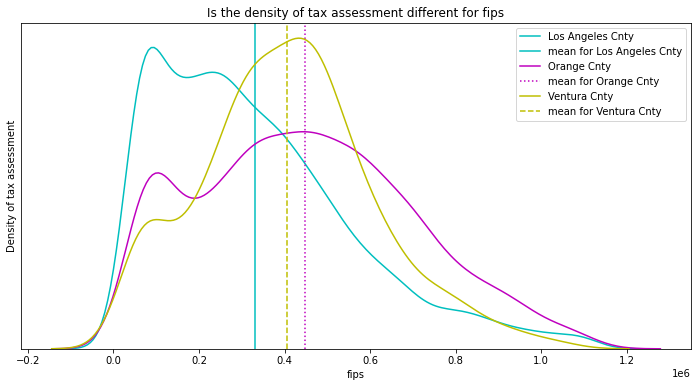

In [7]:
## will do test for homogeneity of variance and pass as flag to TTest using levene test
## samples are sufficent size, and looks mostly normally distributed

explore.cat_and_num_explore_plot(train.sample(n=10000, random_state=123),"fips","tax assessment")

> - ## Takeaway on TTest for FIPS and Tax assessment
> - the 2 sided TTest yielded interesting results in that the the samples of FIPS did varied enough to pass our measure of statistical significance (alpha = .05); rejecting our null hypothesis. This would indicate that seperating the data by FIPS will result in a significant difference. This feature (and its subset Zip) will be  useful in modeling

-
-
-
-
-

> - ## Does the number of Bedrooms have a relation to the number of Bathrooms

> - **Hypothesis 3 -** 
> - alpha = .05
> - $H_0$ = "Amount of bedrooms is independant of the amount bathrooms"
> - $H_a$:  "Amount of bedrooms is not independant of the amount bathrooms"

created an explore function that takes in two features, creates a cross tab of its sub-categories, and returns Chi^2 and p values from chi2_contingency. Plots a scatter graph (alpha .1) with random noise added to each "location" to show density of samples

---
chi^2 = 11401.5412, p = 0.00000, degf = 18
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
( b̶e̶d̶r̶o̶o̶m̶s̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶s̶ )


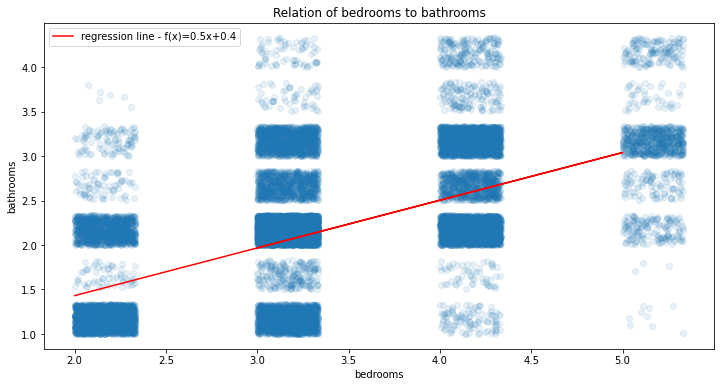

In [8]:
#passes two series into an explore function created for this use case
explore.chi2_for_two(train.bedrooms,train.bathrooms)

> - ## Takeaway on CHI2 for Bedrooms and Bathroom
> - The CHI^2 test provided a statistically significant result that allows us to reject our null hypothesis that bedrooms is independant of bathrooms, signifiying that there is a relationship that we can utilize in our modeling (feature engineering openess)

-
-
-
-
-

> - # Do houses have a different Tax assessments depending on its SQFT?

> - **Hypothesis 4 -** 
> - alpha = .05
> - $H_0$ = "Tax assessment of Area (quantile) has identical average assessments to Tax assessment of other Area (quantiled)"
> - $\mu_{Tax assessment (Area_{n})} = \mu_{Tax assessment (Area_{n+1})}$.
> -
> - $H_a$: "Tax assessment of Area (quantile) does not have identical average assessments to Tax assessment of other Area (quantiled)"
> - $\mu_{Tax assessment (Area_{n})}  /= \mu_{Tax assessment (Area_{n+1})}$. 

created an explore function that takes in two features, returns a variance check (Levene), and passes a flag to the TTest (equal variance). Returns t and p values from TTest for each category of the discrete feature. Plots a cat graph with toggled sub categories and a density line chart with Mean vertical lines for each sub category

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=362.86923, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶H̶o̶u̶s̶e̶ ̶s̶q̶f̶t̶ ̶q̶u̶a̶n̶t̶i̶l̶e̶d̶<̶2̶5̶%̶ ̶p̶e̶r̶c̶e̶n̶t̶i̶l̶e̶ ̶a̶r̶e̶a̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶H̶o̶u̶s̶e̶ ̶s̶q̶f̶t̶ ̶q̶u̶a̶n̶t̶i̶l̶e̶d̶2̶5̶%̶~̶5̶0̶%̶ ̶p̶e̶r̶c̶e̶n̶t̶i̶l̶e̶ ̶a̶r̶e̶a̶ ) t=-27.79397, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=221.92842, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶H̶o̶u̶s̶e̶ ̶s̶q̶f̶t̶ ̶q̶u̶a̶n̶t̶i̶l̶e̶d̶5̶0̶%̶~̶7̶5̶%̶ ̶p̶e̶r̶c̶e̶n̶t̶i̶l̶e̶ ̶a̶r̶e̶a̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶H̶o̶u̶s̶e̶ ̶s̶q̶f̶t̶ ̶q̶u̶a̶n̶t̶i̶l̶e̶d̶2̶5̶%̶~̶5̶0̶%̶ ̶p̶e̶r̶

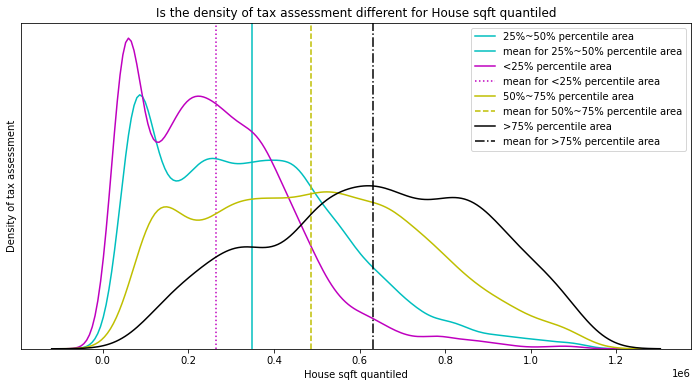

In [9]:
#created a new feature that bins area by quantile
train["House sqft quantiled"] = pd.cut(train.area,4,labels=["<25% percentile area","25%~50% percentile area","50%~75% percentile area",">75% percentile area"])

explore.cat_and_num_explore_plot(train,"House sqft quantiled","tax assessment")

> - ## Takeaway on TTest for Tax assessment by area quartiled
> - the 2 sided TTest yielded interesting results in that the the samples of Area percentile yielded a varied enough Signal/Noise ratio to have statistical significance (alpha = .05); rejecting our null hypothesis. This would indicate that utilizing area (or a combination of it and bathrooms+bedrooms with the feature "openess") to help predict Tax Assessment would be beneficial

-
-
-
-
-

# Verify feature selection going into modeling
we see above that most of our features have bearing on assessment, we will drop decade built since it is more explicitly shown in year built.

we will also run SelectKbest and Recursive Feature Elimination as a sanity check

In [10]:
#drops out decade and splits the features to run in the sanity check feature selection
df.drop(columns="decade built",inplace=True)
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = wrangle.split_tvt_continuous(df,"tax assessment")
#sanity check for features from kbest and RFE (wrangle functions)
print("-----------------------------\n")
wrangle.select_kbest(X_train.drop(columns="fips"),y_train,3)
print("^^^^^^^^^^^^KBest^^^^^^^^^^\n")
print("-----------------------------\n")
print("vvvvvvvvvvvvvRFEvvvvvvvvvvvvv")
wrangle.rfe(X_train.drop(columns="fips"),y_train,3)

train -> (24423, 10)
validate -> (8142, 10)
test -> (8142, 10)
-----------------------------

['bathrooms', 'area', 'yard ratio']
^^^^^^^^^^^^KBest^^^^^^^^^^

-----------------------------

vvvvvvvvvvvvvRFEvvvvvvvvvvvvv
            rfe_ranking
bedrooms              1
bathrooms             1
yard ratio            1


,Var,Rank
0,bedrooms,1
1,bathrooms,1
7,yard ratio,1
6,openess,2
2,area,3
3,year built,4
4,lot sqft,5
5,zip,6


# Exploration Summarized
Some of our features have a good correlation or weight in deciding Tax Assessment and we will keep them for modeling, while others we will drop

-
-
-
-
-
-
-
-
-
-

# Modeling
After reviewing the exploratory analysis we will drop FIPS, this is due to using Zip which is a more precisse representation of geographic area. we will also drop lot sqft due to low relation value with Tax assessment

In [11]:
##list of features to pass through the wrangle function for min max scaling, splits the train into x and y

xlist = train.drop(columns=["tax assessment","fips","bathrooms","bedrooms","lot sqft"]).columns.tolist()

y_train, y_validate, y_test = train["tax assessment"], validate["tax assessment"], test["tax assessment"]

X_train_scaled, X_validate_scaled, X_test_scaled = \
    wrangle.min_max_scale(train, validate, test, xlist)

In [12]:
#sets the baseline and returns a new columns and metrics based on it
y_train,y_validate,metric_df = modeling.model_baseline(y_train,y_validate,"tax assessment")

RMSE using Mean
Train/In-Sample:  239064.38 
Validate/Out-of-Sample:  240583.14
RMSE using Median
Train/In-Sample:  241436.71 
Validate/Out-of-Sample:  242934.62


# Baseline modeling takeaways
we ran two basic models using the mean and the median, and utilized the Root Mean Squared Error as the determinate for which to keep moving forward (lowest value). This time it was Mean, with a RMSE of apporx 240k

In [13]:
#gets the predictions and metrics from polynomial modeling
y_train,y_validate,temp = \
        modeling.model_polynomial(X_train_scaled,X_validate_scaled,y_train,y_validate,"tax assessment",4)

metric_df = pd.concat([metric_df,temp],axis=0).reset_index(drop=True)
metric_df

RMSE for Polynomial Model, degrees=4
Training/In-Sample:  200560.74027865613 
Validation/Out-of-Sample:  201358.39623162453


,model,rmse_train,rmse_validate,r^2_validate
0,baseline_mean,239064.384317,240583.137891,0.000000
1,Polynomial - degree 4,200560.740279,201358.396232,0.299538


# Polynomial modeling takeaways
Playing with the degrees to come to a decent 'average" and range between the trian and validate set, 4 degrees was the best optimization for my features (still large error)

In [14]:
# runs the train and validate through the linear regresion OLS modeling for predictions and metrics
y_train,y_validate,temp = \
    modeling.model_linreg(X_train_scaled,X_validate_scaled,y_train,y_validate,"tax assessment")
    
metric_df = pd.concat([metric_df,temp],axis=0).reset_index(drop=True)
metric_df

RMSE for OLS using LinearRegression
Training/In-Sample:  214247.8320202567 
Validation/Out-of-Sample:  214856.16936339054


,model,rmse_train,rmse_validate,r^2_validate
0,baseline_mean,239064.384317,240583.137891,0.000000
1,Polynomial - degree 4,200560.740279,201358.396232,0.299538
2,OLS Linear Regression,214247.832020,214856.169363,0.202436


# OLS modeling takeaways
OLS was not an improvement over current best of Polynomial, though the RMSE is not too far off (~5%)

In [15]:
# runs the train and validate through the lasso lars modeling for predictions and metrics
y_train,y_validate,temp = \
      modeling.model_l_lars(X_train_scaled,X_validate_scaled,y_train,y_validate,"tax assessment")
    
metric_df = pd.concat([metric_df,temp],axis=0).reset_index(drop=True)
metric_df

RMSE for Lasso + Lars
Training/In-Sample:  214247.8320202567 
Validation/Out-of-Sample:  214856.16936339054


,model,rmse_train,rmse_validate,r^2_validate
0,baseline_mean,239064.384317,240583.137891,0.000000
1,Polynomial - degree 4,200560.740279,201358.396232,0.299538
2,OLS Linear Regression,214247.832020,214856.169363,0.202436
3,Lasso Lars,214247.832020,214856.169363,0.202436


# Lasso Lars modeling takeaways
LL was not an improvement over current best of Polynomial, the parameter tuning ended up yeilding same results as OLS

In [16]:
#runs train and validate through the tweedie modeling for predictions and metrics
y_train,y_validate,temp = \
      modeling.model_tweedie_reg(X_train_scaled,X_validate_scaled,y_train,y_validate,"tax assessment")

metric_df = pd.concat([metric_df,temp],axis=0).reset_index(drop=True)
metric_df

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  214247.8320202567 
Validation/Out-of-Sample:  214856.16936159346


,model,rmse_train,rmse_validate,r^2_validate
0,baseline_mean,239064.384317,240583.137891,0.000000
1,Polynomial - degree 4,200560.740279,201358.396232,0.299538
2,OLS Linear Regression,214247.832020,214856.169363,0.202436
3,Lasso Lars,214247.832020,214856.169363,0.202436
4,Tweedie Reg,214247.832020,214856.169362,0.202436


# Tweedie Regression modeling takeaways
TR was not an improvement over current best of Polynomial, the parameter tuning ended up yeilding same results as OLS and Lasso Lars. Changing the power or alpha yielded higher RMSE

## Comparison of density for models to density of actual

In [17]:
## creates a histogram of the model predictions and the actual 
# for a visual comparison of how the models predicted compared to actual

fig = px.histogram(y_train,x=y_train.drop(columns=["mean","median"]).columns.tolist(),
            barmode="overlay",title = "Model predictions compared to actual",
            color_discrete_map = {0:'red',1:'orange',2:'yellow',3:'green',4:'blue',5:'indigo',6:'purple'})
fig.update_layout(xaxis = dict(tickmode = 'array',tickvals = [0,  100000,  200000,  300000,  400000,  500000,  600000,700000,  800000,  900000, 1000000],ticktext = [0,100000, 200000,  300000,  400000,  500000,  600000,700000,  800000,  900000, 1000000]))
fig.show()

## Opting to use Polynomial Regression for the final test predictions
- almost all the other model performances where similar to each other (within 5%), with this one being best having an RMSE roughly 17% less than baseline

In [18]:
#runs the train and test set through polynomial modeling at 4 degrees to get predictions on the test set and metrics
y_train,y_test,temp = \
        modeling.poly_final(X_train_scaled,X_test_scaled,y_train,y_test,"tax assessment",4)
temp

RMSE for Polynomial Model, degrees=4
Training/In-Sample:  200560.74027865613 
Test/Out-of-Sample:  202886.5045382822


,model,rmse_train,rmse_test,r^2_test
0,Polynomial - degree 4,200560.740279,202886.504538,0.28063


# TEST - Polynomial modeling takeaways
The result of the Polynomial model on the test set was similar to the valiation, (good sign). Showing slight overfit (1%). This still yielded better results than my other models.

-
-
-
-


# IN CONCLUSION
- #### The models used to predict Tax Assessment, while better than baseline, are unsuitable for real world.
- Having an RMSE with values yielding 20% improvement on standard deviation are not very usable in the real world for this type of industry.
- Various features did help improve the model, with the feature engineering of Area / (Bathrooms and Bedrooms) as well as the Lot Size / Area to achieve the 20% that was attained

## Key Takeaway
- Area, lot size, bedrooms, bathrooms, location are all very important aspects that determine Tax Assessment as well as their derivative features (Openness and Yard Ratio)
- More data would alway be beneficial. Using a version of classification to determine key characteristics (comparables and Mill rate / levies / local taxes), and then utilizing a regression model on the similar properties would give a much lower RMSE

## Next Steps
- Determine and Collect additional data that are key factors in determining Tax Assessment
- Utilize either a combination of models or a new style of model to more accurately predict Tax Assessment

## Recommendation
- Let Maggie know if she lost an email that there are methods to "find" said email to ensure data integrity rather than using an external source (assumption of match).
- Determine how local areas calculate tax rate and use a model that is structured similarly.
- Do not recommend using this model to help assist in predicting Tax Assessment